In [2]:
from pathlib import Path 
import pandas as pd
import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns 
from feature_creation import (
    config, 
    csv_preprocess, 
    make_windowed_features,
    read_hdf,
    update_hdf
)

In [3]:
dfraw = read_hdf()

In [20]:
Xy = pd.DataFrame()
for name, training_set in tqdm.tqdm(dfraw.groupby('name')):
    y = training_set['y'].iloc[0]
    xy = make_windowed_features(training_set)
    xy['y'] = y
    Xy = pd.concat([Xy, xy], ignore_index=True)

100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


In [84]:
from sklearn.ensemble import ExtraTreesClassifier

# 7th more importante features -> gives ~93% accuracy in average
selected_features = ['ack_entropy',
        'ttl_entropy',
        'tcp_ack_var',
        'udp_nports',
        'pkt_entropy',
        'dw_pkt_avg',
        'dw_ttl_avg',
        'dw_ttl_unique',
        'dw_pkt_entropy',
        'dl_pkt_avg']

# to make 100 random splits to get the most important features on average
selected_features = Xy.columns.to_list() # all features -> gives a bit worse p 95%

if 'y' in selected_features:
    selected_features.remove('y')  

scores = []
feature_importances = np.zeros(len(selected_features))
for i in range(100): # making 100 random splits
    X = Xy.sample(frac=1) # shuffle samples
    size = len(X)
    ratio = 0.8 # 0.8 for training
    X = X[X[selected_features].columns.to_list() + ['y']] # reducing features
    X_train, y_train = X.drop(columns=['y']).iloc[:int(ratio*size)], X['y'].iloc[:int(ratio*size)]
    X_score, y_score = X.drop(columns=['y']).iloc[int(ratio*size):], X['y'].iloc[int(ratio*size):]

    # Train the model        
    etree = ExtraTreesClassifier(n_estimators=100, random_state=42)
    etree.fit(X_train, y_train)
    feature_importances += etree.feature_importances_
    # index = 1500
    # sample = pd.DataFrame(X.iloc[index]).transpose()
    # print(etree.predict_proba(sample), y.iloc[index])
    score = 100*etree.score(X_score, y_score)
    print(f"Mean accuracy {i:3d} is {score: .2f} %", end='\r')
    scores.append(score)
    
print(f"Average of {i} random splits - mean accuracy is {np.mean(np.array(scores)): .2f} %")
feature_importances /= i+1
feature_importances = pd.Series(feature_importances, index=selected_features)

Average of 99 random splits - mean accuracy is  94.03 %


<Axes: >

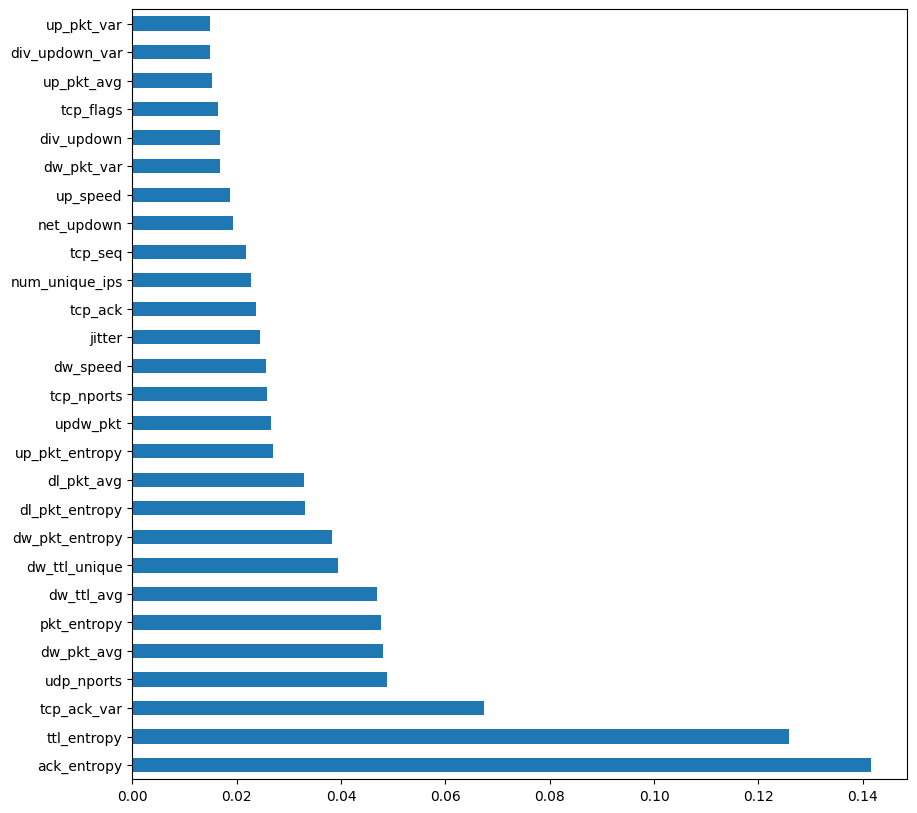

In [85]:
plt.figure(figsize=(10,10))
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.plot(kind='barh')

In [70]:
feature_importances.index[:10].to_list()

['ack_entropy',
 'ttl_entropy',
 'tcp_ack_var',
 'udp_nports',
 'pkt_entropy',
 'dw_pkt_avg',
 'dw_ttl_avg',
 'dw_ttl_unique',
 'dw_pkt_entropy',
 'dl_pkt_avg']

<Axes: >

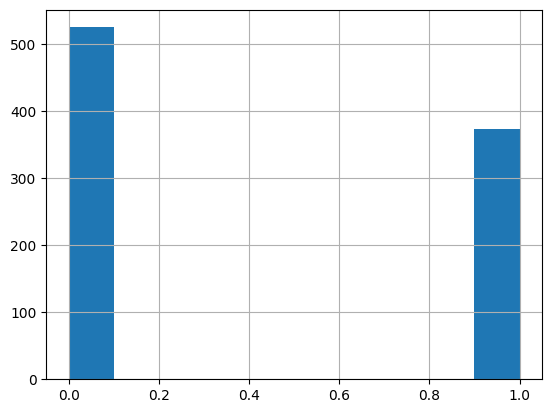

In [27]:
Xy.y.hist()

In [82]:
np.percentile(np.array(scores), [5, 10, 50, 90]) # 95% time its above 91% acuracy x

array([90.55555556, 91.61111111, 93.88888889, 96.11111111])

In [77]:
import joblib

In [83]:
joblib.dump(etree, 'etree.joblib')

['etree.joblib']